In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col

import matplotlib.pyplot as plt

In [5]:
# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("DDAM Project") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

## Import

In [6]:
df_boxscore = spark.read.csv("data/boxscore_clean.csv", header=True, inferSchema=True)

In [7]:
print(df_boxscore.count())

539171


In [8]:
# Renaming
df_boxscore = df_boxscore.withColumnRenamed("pos_clean", "Position")

In [9]:
df_boxscore.printSchema()

root
 |-- playerName: string (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- teamName: string (nullable = true)
 |-- FG: integer (nullable = true)
 |-- FGA: integer (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- FT: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- TRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- seasonStartYear: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- Ht: string (nullable = true)
 |-- Wt: double (nullable = true)
 |-- feet: double (nullable = true)
 |-- inches: string (nullable = true)
 |-- MP_seconds: integer (n

In [10]:
# classes
categorical_columns = ['Position']

for column in categorical_columns:
    distinct_classes = df_boxscore.groupBy(column).count().collect()

distinct_classes

[Row(Position='F', count=224245),
 Row(Position='C', count=82184),
 Row(Position='G', count=232742)]

## Position one-hot-enconding

In [11]:
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Position", outputCol="PosNum", handleInvalid="skip")

df_boxscore = indexer.fit(df_boxscore).transform(df_boxscore)

In [12]:
from pyspark.ml.feature import OneHotEncoder
onehotencoder_embarked_vector = OneHotEncoder(inputCol="PosNum", outputCol="PosVec")
df_boxscore = onehotencoder_embarked_vector.fit(df_boxscore).transform(df_boxscore)
df_boxscore.show()

+------------------+-------+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----+-----+------------------+------+----------+--------+-------------------+-------------------+-------------------+------+-------------+
|        playerName|game_id|            teamName| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|  Ht|   Wt|              feet|inches|MP_seconds|Position|                TSP|                EFG|           TO_ratio|PosNum|       PosVec|
+------------------+-------+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----+-----+------------------+------+----------+--------+-------------------+-------------------+-------------------+------+-------------+
|Corliss Williamson|      1|    Sacramento Kings|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|           19

In [13]:
column2drop = ('playerName', 'game_id', 'teamName', 'seasonStartYear', 'Ht', 'Pos', 'Position', 'Wt', 'feet', 'inches')
df_boxscore = df_boxscore.drop(*column2drop)

In [14]:
# removing correlated features
too_correlated = ('FG', 'FT', 'TRB', 'TSP')
df_boxscore = df_boxscore.drop(*too_correlated)

In [15]:
df_boxscore.printSchema()

root
 |-- FGA: integer (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- MP_seconds: integer (nullable = true)
 |-- EFG: double (nullable = true)
 |-- TO_ratio: double (nullable = true)
 |-- PosNum: double (nullable = false)
 |-- PosVec: vector (nullable = true)



## Data understanding

In [16]:
# Are data balanced?
categorical_columns = ['PosNum']

for column in categorical_columns:
    distinct_values = df_boxscore.groupBy(column).count().collect()
    print(f"Distinct values and frequencies in {column}:")
    for row in distinct_values:
        value = row[column]
        frequency = row["count"]
        print(f"{value}: {frequency}")
    print()

Distinct values and frequencies in PosNum:
0.0: 232742
1.0: 224245
2.0: 82184



## Data preparation

In [17]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [18]:
num_col = [item[0] for item in df_boxscore.dtypes if not item[1].startswith('string')]
num_col.remove("PosNum")
num_col.remove("PosVec")
print(num_col)

['FGA', '3P', '3PA', 'FTA', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '+/-', 'isStarter', 'isRegular', 'MP_seconds', 'EFG', 'TO_ratio']


In [19]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Selezionare tutte le colonne
selected_columns = num_col

# Creare un VectorAssembler
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")

# Applicare l'assemblatore
output_dataset = assembler.transform(df_boxscore)

# Creare uno scaler per normalizzare le features
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

# Applicare lo scaler
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
output_dataset.show(5)

+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------+----------+-------------------+-------------------+------+-------------+--------------------+--------------------+
|FGA| 3P|3PA|FTA|ORB|DRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|isRegular|MP_seconds|                EFG|           TO_ratio|PosNum|       PosVec|            features|     features_scaled|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------+----------+-------------------+-------------------+------+-------------+--------------------+--------------------+
| 11|  0|  0|  0|  1|  3|  4|  1|  1|  4|  5| 14| -2|        1|        1|      2240| 0.6363636363636364|0.21052631578947367|   1.0|(2,[1],[1.0])|[11.0,0.0,0.0,0.0...|[0.25,0.0,0.0,0.0...|
|  4|  0|  0|  4|  2|  5|  3|  1|  0|  4|  3|  1|-12|        1|        1|      1894|                0.0|0.31347962382445144|   2.0|    (2,[],[])|[4.0,0.0,0.0,4.0,...|[0.09090909090909...|
| 13|  1|  2|  2|  0|  2|  5|  1|  1|  2|  2| 17| -7|       

In [20]:
classificationData = output_dataset.select("features_scaled", "PosNum")

classificationData.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features_scaled                                                                                                                                                                                                                                                                          |PosNum|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|[0.25,0.0,0.0,0.0,0.05555555555555555,0.13043478260869565,0.16,0.1,0.07692307692307693,0.3333333333333333,0.7142857142857142,0

In [21]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=1)

In [22]:
# Validation split
(trainingData, valData) = trainingData.randomSplit([0.8, 0.2],seed=1)

In [23]:
trainingData.show(100, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features_scaled                                                                                                                                                                                                                          |PosNum|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|(18,[0,1,2,3,4,5,11,12,15,16],[0.06818181818181818,0.07142857142857142,0.041666666666666664,0.05128205128205128,0.05555555555555555,0.043478260869565216,0.09999999999999999,0.5614035087719298,0.02539763981528989,0.7777777777777778]) |0.0   |
|(18,[0,1,2,3,4,5,11,12,15,1

## Decision Tree

In [24]:
def plot_importance(importance):
    keys = importance.keys()
    values = importance.values()

    # Plot the dictionary
    plt.figure(figsize=(17,5))
    plt.bar(keys, values)
    plt.xlabel("Keys")
    plt.ylabel("Values")
    plt.title("Feature importance")
    plt.show()

In [25]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
import random
import itertools

"""# random search
hyperparameters = {
    'maxDepth': [3, 5, 7, 9],
    'maxBins' : [16, 32, 64],
    'impurity' : ['gini', 'entropy']
}

number_of_combinations = 6
random_combinations = random.sample(list(itertools.product(*hyperparameters.values())), number_of_combinations)

for combo in random_combinations:
    param_dict = dict(zip(hyperparameters.keys(), combo))

    dt = DecisionTreeClassifier(labelCol="PosNum", featuresCol="features_scaled", impurity=param_dict['impurity'], maxDepth=param_dict['maxDepth'], maxBins=param_dict['maxBins'])

    dt = dt.fit(trainingData)

    importance = {}
    featureImportances = list(dt.featureImportances)

    for i,e in enumerate(featureImportances):
        importance[num_col[i]] = e
    
    plot_importance(importance)

    # Make predictions
    predictions = dt.transform(valData)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(labelCol="PosNum"
                                                , predictionCol="prediction"
                                                , metricName="accuracy")

    print('With parameters', param_dict)
    accuracy = evaluator.evaluate(predictions)
    print('Validation accuracy =', accuracy)
"""

'# random search\nhyperparameters = {\n    \'maxDepth\': [3, 5, 7, 9],\n    \'maxBins\' : [16, 32, 64],\n    \'impurity\' : [\'gini\', \'entropy\']\n}\n\nnumber_of_combinations = 6\nrandom_combinations = random.sample(list(itertools.product(*hyperparameters.values())), number_of_combinations)\n\nfor combo in random_combinations:\n    param_dict = dict(zip(hyperparameters.keys(), combo))\n\n    dt = DecisionTreeClassifier(labelCol="PosNum", featuresCol="features_scaled", impurity=param_dict[\'impurity\'], maxDepth=param_dict[\'maxDepth\'], maxBins=param_dict[\'maxBins\'])\n\n    dt = dt.fit(trainingData)\n\n    importance = {}\n    featureImportances = list(dt.featureImportances)\n\n    for i,e in enumerate(featureImportances):\n        importance[num_col[i]] = e\n    \n    plot_importance(importance)\n\n    # Make predictions\n    predictions = dt.transform(valData)\n\n    # Select (prediction, true label) and compute test error\n    evaluator = MulticlassClassificationEvaluator(labelC

In [26]:
dt = DecisionTreeClassifier(labelCol="PosNum", featuresCol="features_scaled", impurity='entropy', maxDepth=9, maxBins=64)

dt = dt.fit(trainingData)

In [27]:
dt.featureImportances

SparseVector(18, {0: 0.0034, 1: 0.0001, 2: 0.4186, 3: 0.0002, 4: 0.1492, 5: 0.1369, 6: 0.1834, 7: 0.0004, 8: 0.092, 9: 0.0002, 10: 0.0047, 11: 0.0002, 12: 0.0001, 13: 0.0042, 15: 0.0052, 16: 0.0009, 17: 0.0001})

In [28]:
importance = {}
featureImportances = list(dt.featureImportances)

for i,e in enumerate(featureImportances):
    importance[num_col[i]] = e

importance

{'FGA': 0.003411064657067892,
 '3P': 6.292538939838853e-05,
 '3PA': 0.41861195009827545,
 'FTA': 0.00024245687765244914,
 'ORB': 0.14918796260054804,
 'DRB': 0.1369044957732151,
 'AST': 0.18344192422363564,
 'STL': 0.00044350051003409237,
 'BLK': 0.0920348733615934,
 'TOV': 0.00022304453337339028,
 'PF': 0.004744277035651021,
 'PTS': 0.0001792061429452136,
 '+/-': 9.217766187432809e-05,
 'isStarter': 0.004235811993698466,
 'isRegular': 0.0,
 'MP_seconds': 0.005158978060959052,
 'EFG': 0.0009463719577740148,
 'TO_ratio': 7.897912230412065e-05}

In [47]:
print(distinct_classes)
print(distinct_values)

[Row(Position='F', count=224245), Row(Position='C', count=82184), Row(Position='G', count=232742)]
[Row(PosNum=0.0, count=232742), Row(PosNum=1.0, count=224245), Row(PosNum=2.0, count=82184)]


In [52]:
# creates mapping
# need to update this dictionary
class_mapping = {}

for i in range(len(distinct_classes)):
    for j in range(len(distinct_values)):
        #print(distinct_classes[i][1], distinct_values[j][1], 'classes:', distinct_values[i][0], distinct_classes[j][0])
        if distinct_classes[i][1] == distinct_values[j][1]:
            class_mapping[distinct_values[j][0]] = distinct_classes[i][0]

class_mapping

{1.0: 'F', 2.0: 'C', 0.0: 'G'}

In [59]:
# Make predictions
predictions = dt.transform(testData)

predictions.show(10)

+--------------------+------+--------------------+--------------------+----------+
|     features_scaled|PosNum|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(18,[0,1,2,3,4,5,...|   0.0|[1189.0,2091.0,13...|[0.34806791569086...|       1.0|
|(18,[0,1,2,3,4,6,...|   0.0|[12655.0,3711.0,1...|[0.76585572500605...|       0.0|
|(18,[0,1,2,3,4,10...|   0.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18,[0,1,2,3,4,10...|   0.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18,[0,1,2,3,4,10...|   0.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18,[0,1,2,3,4,10...|   0.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18,[0,1,2,3,4,10...|   2.0|  [607.0,762.0,59.0]|[0.42507002801120...|       1.0|
|(18,[0,1,2,3,4,11...|   0.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18

In [60]:
predictionAndLabel = predictions.select("prediction", "PosNum").rdd

In [61]:
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabel)

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


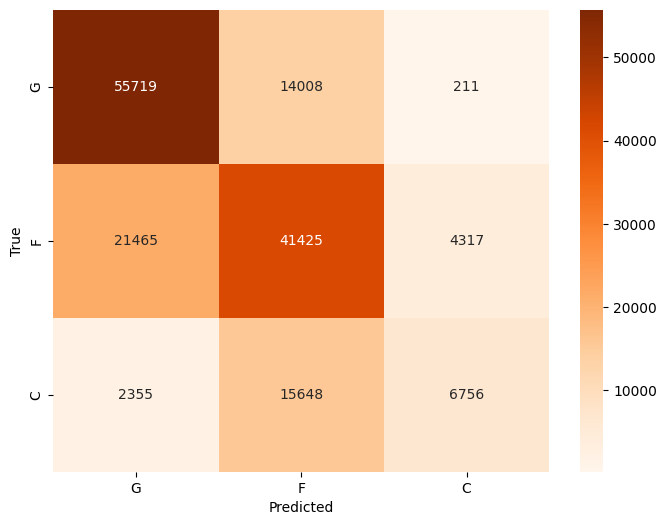

In [62]:
import seaborn as sns

confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_matrix, annot=True, cmap="Oranges", fmt='g')  # fmt='g' suppresses scientific notation

# Map the numerical values to genres using the dictionary
ax.set_xticklabels([class_mapping.get(int(label.get_text()), "") for label in ax.get_xticklabels()])
ax.set_yticklabels([class_mapping.get(int(label.get_text()), "") for label in ax.get_yticklabels()])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [63]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="PosNum"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print('Validation accuracy =', accuracy)
print("Validation Error = %g" % (1.0 - accuracy))

predictions_test = dt.transform(testData)
accuracy_test = evaluator.evaluate(predictions_test)
print('Test accuracy =', accuracy_test)
print("Test Error = %g" % (1.0 - accuracy_test))

Validation accuracy = 0.6417383140626544
Validation Error = 0.358262
Test accuracy = 0.6417383140626544
Test Error = 0.358262


Using 'Ht', the decision tree obtains nearly 89% of accuracy. Without it, we reach 65% accuracy on the validation set.

## Multilayer Perceptron Classifier

In [64]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

layers = [18, 30, 30, 3]  # Define the layers of the neural network
mlp = MultilayerPerceptronClassifier(labelCol="PosNum", featuresCol="features_scaled", layers=layers, seed=42, maxIter=80, stepSize=0.01)

model = mlp.fit(trainingData)

predictions = model.transform(valData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="PosNum", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Validation accuracy:", accuracy)

Validation accuracy: 0.6557068673166596


In [65]:
# Make predictions
predictions = model.transform(testData)

predictions.show(10)

+--------------------+------+--------------------+--------------------+----------+
|     features_scaled|PosNum|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(18,[0,1,2,3,4,5,...|   0.0|[0.04031830526481...|[0.43515480465190...|       1.0|
|(18,[0,1,2,3,4,6,...|   0.0|[0.93084001962622...|[0.78093387715486...|       0.0|
|(18,[0,1,2,3,4,10...|   0.0|[-0.1940246101709...|[0.53285865891773...|       0.0|
|(18,[0,1,2,3,4,10...|   0.0|[-0.0702639552676...|[0.57485367500457...|       0.0|
|(18,[0,1,2,3,4,10...|   0.0|[-1.0001244423767...|[0.30430706195162...|       1.0|
|(18,[0,1,2,3,4,10...|   0.0|[-0.1990230787066...|[0.53652037617946...|       0.0|
|(18,[0,1,2,3,4,10...|   2.0|[-0.8132736382805...|[0.34103140908016...|       1.0|
|(18,[0,1,2,3,4,11...|   0.0|[-0.4088711972788...|[0.47860480509105...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[-0.0915881525722...|[0.56822372880220...|       0.0|
|(18

In [66]:
# to create an heatmap
predictionAndLabel = predictions.select("prediction", "PosNum").rdd

from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabel)

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


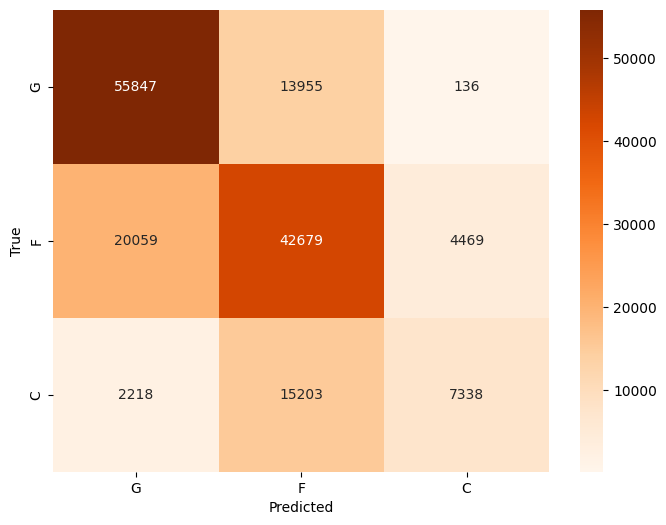

In [67]:
import seaborn as sns

confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_matrix, annot=True, cmap="Oranges", fmt='g')  # fmt='g' suppresses scientific notation

# Map the numerical values to genres using the dictionary
ax.set_xticklabels([class_mapping.get(int(label.get_text()), "") for label in ax.get_xticklabels()])
ax.set_yticklabels([class_mapping.get(int(label.get_text()), "") for label in ax.get_yticklabels()])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Random search

In [39]:
import random
import itertools

# random search
"""hyperparameters = {
    'layer_size': [10, 20, 30, 40],
    'stepsize' : [0.005, 0.01, 0.03, 0.05],
    'layers': [2, 3, 4, 5],   # Define the layers of the neural network
    'epochs': [40, 60, 80],
}

number_of_combinations = 10
random_combinations = random.sample(list(itertools.product(*hyperparameters.values())), number_of_combinations)

num_classes = 3

for i, combo in enumerate(random_combinations):
    param_dict = dict(zip(hyperparameters.keys(), combo))

    layers = [18]
    for _ in range(param_dict['layers']):
        layers.append(param_dict['layer_size'])
    layers.append(num_classes)

    mlp = MultilayerPerceptronClassifier(labelCol="PosNum", featuresCol="features_scaled", layers=layers, stepSize=param_dict['stepsize'], maxIter=param_dict['epochs'])

    model = mlp.fit(trainingData)

    predictions = model.transform(valData)

    # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(labelCol="PosNum", predictionCol="prediction", metricName="accuracy")
    print('With parameters', param_dict)
    accuracy = evaluator.evaluate(predictions)
    print("Validation accuracy for combo {}:".format(i), accuracy)
"""

'hyperparameters = {\n    \'layer_size\': [10, 20, 30, 40],\n    \'stepsize\' : [0.005, 0.01, 0.03, 0.05],\n    \'layers\': [2, 3, 4, 5],   # Define the layers of the neural network\n    \'epochs\': [40, 60, 80],\n}\n\nnumber_of_combinations = 10\nrandom_combinations = random.sample(list(itertools.product(*hyperparameters.values())), number_of_combinations)\n\nnum_classes = 3\n\nfor i, combo in enumerate(random_combinations):\n    param_dict = dict(zip(hyperparameters.keys(), combo))\n\n    layers = [18]\n    for _ in range(param_dict[\'layers\']):\n        layers.append(param_dict[\'layer_size\'])\n    layers.append(num_classes)\n\n    mlp = MultilayerPerceptronClassifier(labelCol="PosNum", featuresCol="features_scaled", layers=layers, stepSize=param_dict[\'stepsize\'], maxIter=param_dict[\'epochs\'])\n\n    model = mlp.fit(trainingData)\n\n    predictions = model.transform(valData)\n\n    # Evaluate the model\n    evaluator = MulticlassClassificationEvaluator(labelCol="PosNum", predi